In [1]:
import numpy as np
import cv2

import PIL.Image as Image
import os
import pathlib
import pandas
import csv
import keras

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split

In [2]:
img_folder = r"data"

df = pandas.read_csv("CoordinateList.csv")
tups = []
for row in df[["NAME", "Label"]].iterrows():
    name = row[1]["NAME"]
    label = row[1]["Label"]
    file_path = os.path.join(img_folder, name)
    for file in os.listdir(file_path):
        # open image and save in the object
        Str = file_path + str("\\") + file
        img_object = cv2.imread(Str)
        img_object_64 = cv2.resize(img_object, (128, 128))
        img_object = np.array(img_object_64)/255
        tups.append((file, img_object_64, img_object, label))
#         print(img_object.shape)

tups[0]
# for monument in df[["NAME", "Label"]]:
#     x = os.listdir(os.path.join(img_folder, monument))
#     print(monument)

('Taj Mahal.png',
 array([[[58, 54, 48],
         [54, 49, 39],
         [90, 75, 67],
         ...,
         [32, 14, 15],
         [31, 13, 14],
         [30, 12, 14]],
 
        [[59, 52, 47],
         [55, 49, 44],
         [76, 66, 58],
         ...,
         [31, 13, 14],
         [32, 14, 15],
         [30, 12, 13]],
 
        [[55, 47, 40],
         [51, 45, 38],
         [59, 53, 46],
         ...,
         [34, 14, 16],
         [33, 13, 15],
         [34, 14, 16]],
 
        ...,
 
        [[47, 39, 45],
         [59, 52, 60],
         [56, 49, 59],
         ...,
         [30, 20, 21],
         [22, 12, 15],
         [55, 51, 55]],
 
        [[59, 52, 63],
         [53, 45, 52],
         [37, 26, 35],
         ...,
         [22, 11, 12],
         [22,  5,  9],
         [60, 59, 65]],
 
        [[41, 30, 37],
         [38, 25, 31],
         [54, 39, 48],
         ...,
         [27, 16, 17],
         [27, 11, 16],
         [72, 70, 80]]], dtype=uint8),
 array([[[0.22745098, 0.

In [3]:
X = []
Y = []
names = []
for name, img, x_, y_ in tups:
    X.append((name, img, x_))
    Y.append(float(y_))
X_train_orig, X_test_orig, Y_train, Y_test = train_test_split(X, Y, random_state=0, train_size=0.9)
X_train_names = [_[0] for _ in X_train_orig]
X_train_images = [_[1] for _ in X_train_orig]
X_train = np.array([_[2] for _ in X_train_orig])
X_test_names = [_[0] for _ in X_test_orig]
X_test_images = [_[1] for _ in X_test_orig]
X_test = np.array([_[2] for _ in X_test_orig])
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)
print(X_train.shape)
print(Y_train.shape)
#X_train = np.array(X_train_orig[1])
#X_test = np.array(X_test_orig[1])
#X_train
#X = np.array(X)
#Y = np.array(Y)

#print("Train Size", len(X_train))
#print("Test Size", len(X_test))
#X_train.shape

(345, 128, 128, 3)
(345,)


In [4]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(128, 128),
  layers.experimental.preprocessing.Rescaling(1.0),
])

In [5]:
cnn = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(filters=37, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:]),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=29, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=13, kernel_size=(5, 5), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=7, kernel_size=(5, 5), activation='relu'),
    layers.Flatten(),
    layers.Dense(13, activation='relu'), 
    layers.Dense(7, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
cnn.build(input_shape=X_train.shape)

In [6]:
metrics = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]
cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=metrics)

In [7]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (345, 128, 128, 3)        0         
                                                                 
 conv2d (Conv2D)             (345, 126, 126, 37)       1036      
                                                                 
 max_pooling2d (MaxPooling2D  (345, 63, 63, 37)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (345, 61, 61, 29)         9686      
                                                                 
 max_pooling2d_1 (MaxPooling  (345, 30, 30, 29)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (345, 26, 26, 13)        

In [8]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [9]:
cnn.fit(X_train, Y_train, epochs=100)

Epoch 1/100
11/11 [==============================] - 11s 118ms/step - loss: 0.6290 - tp: 212.0000 - fp: 127.0000 - tn: 3.0000 - fn: 3.0000 - accuracy: 0.6232 - precision: 0.6254 - recall: 0.9860 - auc: 0.6601 - prc: 0.7585
Epoch 2/100
11/11 [==============================] - 0s 27ms/step - loss: 0.6257 - tp: 215.0000 - fp: 126.0000 - tn: 4.0000 - fn: 0.0000e+00 - accuracy: 0.6348 - precision: 0.6305 - recall: 1.0000 - auc: 0.6998 - prc: 0.7647
Epoch 3/100
11/11 [==============================] - 0s 23ms/step - loss: 0.6298 - tp: 213.0000 - fp: 114.0000 - tn: 16.0000 - fn: 2.0000 - accuracy: 0.6638 - precision: 0.6514 - recall: 0.9907 - auc: 0.7051 - prc: 0.7496
Epoch 4/100
11/11 [==============================] - 0s 23ms/step - loss: 0.5906 - tp: 215.0000 - fp: 115.0000 - tn: 15.0000 - fn: 0.0000e+00 - accuracy: 0.6667 - precision: 0.6515 - recall: 1.0000 - auc: 0.8060 - prc: 0.8734
Epoch 5/100
11/11 [==============================] - 0s 23ms/step - loss: 0.5612 - tp: 211.0000 - fp: 10

11/11 [==============================] - 0s 22ms/step - loss: 0.1464 - tp: 194.0000 - fp: 2.0000 - tn: 128.0000 - fn: 21.0000 - accuracy: 0.9333 - precision: 0.9898 - recall: 0.9023 - auc: 0.9878 - prc: 0.9933
Epoch 38/100
11/11 [==============================] - 0s 22ms/step - loss: 0.2376 - tp: 193.0000 - fp: 12.0000 - tn: 118.0000 - fn: 22.0000 - accuracy: 0.9014 - precision: 0.9415 - recall: 0.8977 - auc: 0.9612 - prc: 0.9759
Epoch 39/100
11/11 [==============================] - 0s 22ms/step - loss: 0.1187 - tp: 194.0000 - fp: 1.0000 - tn: 129.0000 - fn: 21.0000 - accuracy: 0.9362 - precision: 0.9949 - recall: 0.9023 - auc: 0.9936 - prc: 0.9963
Epoch 40/100
11/11 [==============================] - 0s 22ms/step - loss: 0.1268 - tp: 195.0000 - fp: 3.0000 - tn: 127.0000 - fn: 20.0000 - accuracy: 0.9333 - precision: 0.9848 - recall: 0.9070 - auc: 0.9906 - prc: 0.9946
Epoch 41/100
11/11 [==============================] - 0s 22ms/step - loss: 0.1113 - tp: 194.0000 - fp: 1.0000 - tn: 129.

11/11 [==============================] - 0s 22ms/step - loss: 0.0293 - tp: 206.0000 - fp: 0.0000e+00 - tn: 130.0000 - fn: 9.0000 - accuracy: 0.9739 - precision: 1.0000 - recall: 0.9581 - auc: 1.0000 - prc: 1.0000
Epoch 74/100
11/11 [==============================] - 0s 22ms/step - loss: 0.0278 - tp: 206.0000 - fp: 0.0000e+00 - tn: 130.0000 - fn: 9.0000 - accuracy: 0.9739 - precision: 1.0000 - recall: 0.9581 - auc: 1.0000 - prc: 1.0000
Epoch 75/100
11/11 [==============================] - 0s 22ms/step - loss: 0.0276 - tp: 206.0000 - fp: 0.0000e+00 - tn: 130.0000 - fn: 9.0000 - accuracy: 0.9739 - precision: 1.0000 - recall: 0.9581 - auc: 1.0000 - prc: 1.0000
Epoch 76/100
11/11 [==============================] - 0s 22ms/step - loss: 0.0285 - tp: 206.0000 - fp: 0.0000e+00 - tn: 130.0000 - fn: 9.0000 - accuracy: 0.9739 - precision: 1.0000 - recall: 0.9581 - auc: 1.0000 - prc: 1.0000
Epoch 77/100
11/11 [==============================] - 0s 22ms/step - loss: 0.1685 - tp: 200.0000 - fp: 10.000

In [10]:
cnn.evaluate(X_test, Y_test)

2/2 [==============================] - 1s 95ms/step - loss: 0.1970 - tp: 17.0000 - fp: 1.0000 - tn: 19.0000 - fn: 2.0000 - accuracy: 0.9231 - precision: 0.9444 - recall: 0.8947 - auc: 0.9697 - prc: 0.9732


[0.19700470566749573,
 17.0,
 1.0,
 19.0,
 2.0,
 0.9230769276618958,
 0.9444444179534912,
 0.8947368264198303,
 0.9697368144989014,
 0.9732407331466675]

In [11]:
def plot_sample(x, y, name):
    plt.figure(figsize = (15,2))
    plt.imshow(x)
    plt.xlabel("Predict: " + ("\"Monument\" " if y >= 0.5 else "\"Random\" ") + "Actual: \""+ str(name) +"\"")

Total tests: 39
All positives: 18
Correct Predictions: 


C:\Users\anike\AppData\Local\Temp\ipykernel_21112\2145563649.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = (15,2))


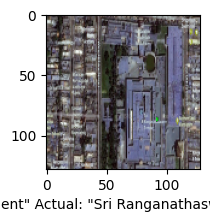

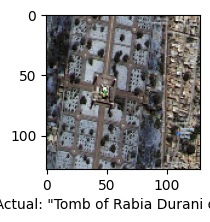

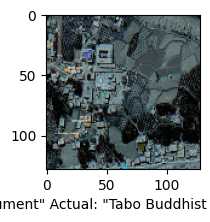

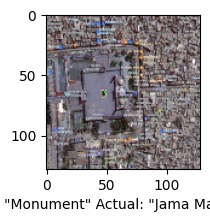

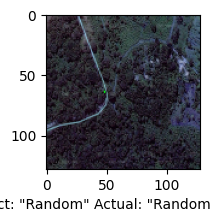

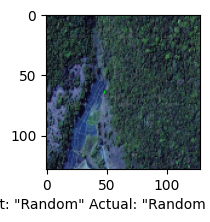

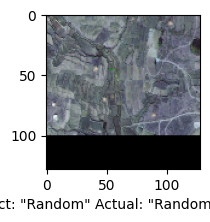

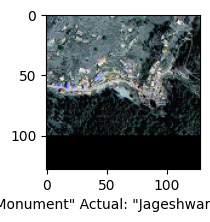

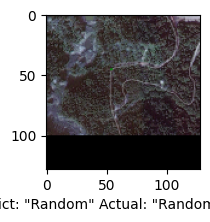

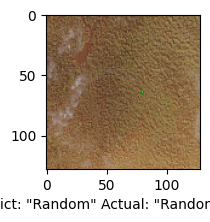

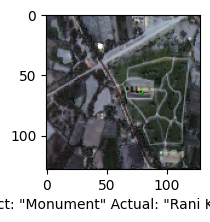

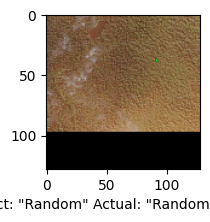

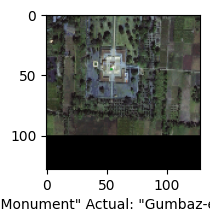

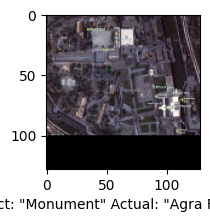

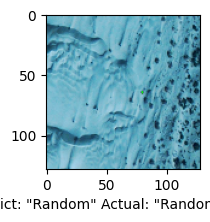

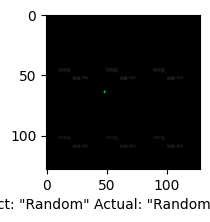

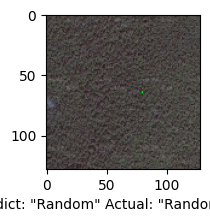

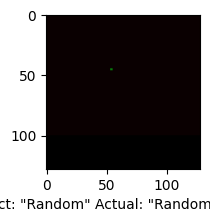

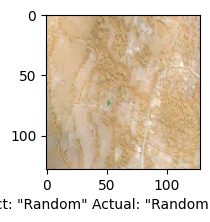

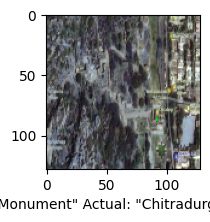

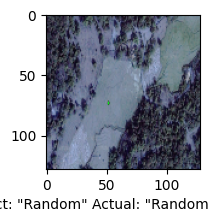

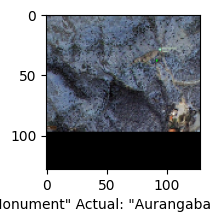

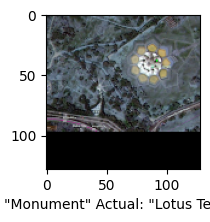

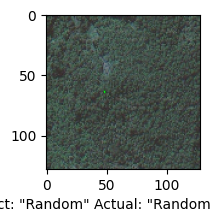

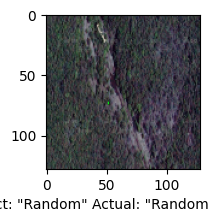

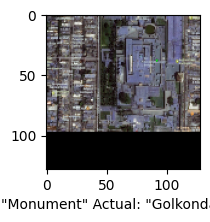

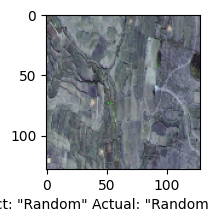

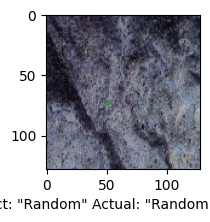

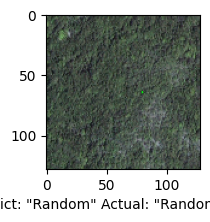

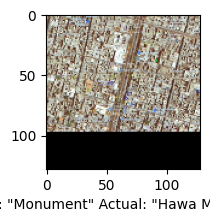

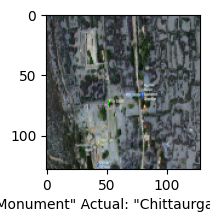

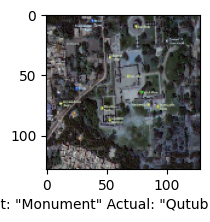

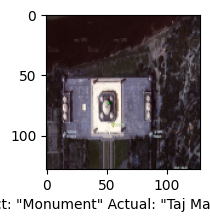

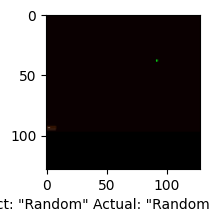

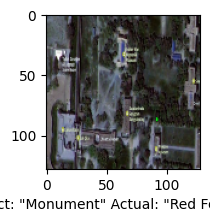

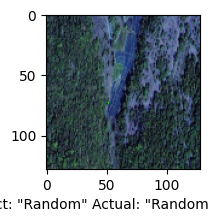

In [12]:
Y_pred = cnn(X_test)
actuals = [1 if pred >= 0.5 else 0 for pred in Y_test]
preds = [1 if pred >= 0.5 else 0 for pred in Y_pred]
print("Total tests:", len(preds))
print("All positives:", sum(preds))

print("Correct Predictions: ")
for name, img, pred, actual in zip(X_test_names, X_test_images, preds, actuals):
    if pred == actual:
        plot_sample(img, pred, name)

Wrong Predictions: 


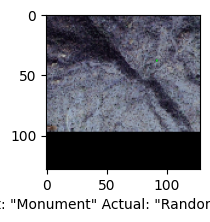

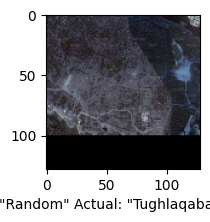

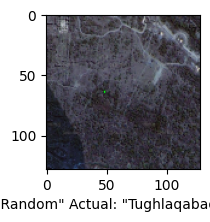

In [13]:
print("Wrong Predictions: ")
for name, img, pred, actual in zip(X_test_names, X_test_images, preds, actuals):
    if pred != actual:
        plot_sample(img, pred, name)

In [17]:
model_version = "OnlyCNN"
cnn.save(f"./saved_models/H5Format/{model_version}", save_format="h5")
# , save_format="h5"